In [1]:
import matplotlib.pyplot as plt
import torch
from models.model import ScikitlearnClassifierSVC, SmallCNN
from poisoning import PoisoningAttackSVM, PoisoningAttackCNN

In [2]:
import os
import numpy as np
from PIL import Image

DATA_DIR = './train'
CLASSES = ['0', '1', '2']
IMG_SIZE = (32, 32) 

X = []
y = []

for class_label in CLASSES:
    class_dir = os.path.join(DATA_DIR, class_label)
    for fname in sorted(os.listdir(class_dir)): 
        if fname.endswith('.png'):
            img_path = os.path.join(class_dir, fname)
            img = Image.open(img_path).resize(IMG_SIZE).convert('RGB')
            img_array = np.array(img).flatten() 
            X.append(img_array)
            y.append(int(class_label))

X = np.array(X, dtype=np.uint8)
y = np.array(y, dtype=np.uint8)

indices = np.random.permutation(len(X))
X = X[indices]
y = y[indices]

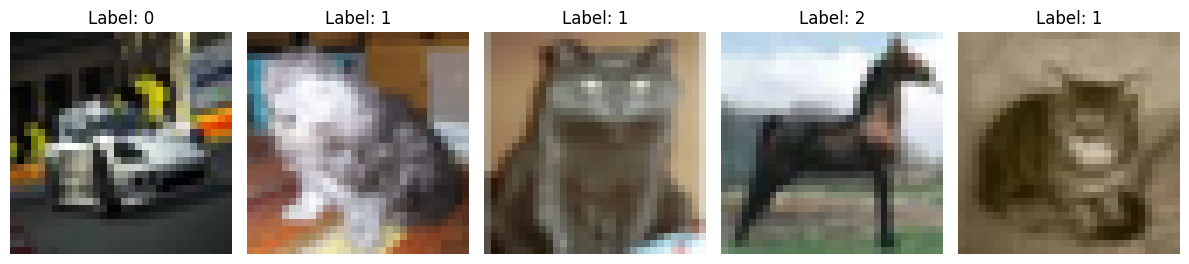

In [3]:
num_images = 5
random_indices = np.random.choice(len(X), size=num_images, replace=False)

fig, axes = plt.subplots(1, num_images, figsize=(12, 4))
for i, idx in enumerate(random_indices):
    ax = axes[i]
    ax.imshow(X[idx].reshape(32, 32, 3))
    ax.axis('off')
    ax.set_title(f'Label: {y[idx]}')
plt.tight_layout()
plt.show()

In [4]:
from sklearn.svm import SVC
from sklearn.metrics import hinge_loss, accuracy_score

In [5]:
target_digit1=1
target_digit2=2

In [6]:
perm1 = np.random.permutation(len(X))
X = X[perm1]
y = y[perm1]

target_digit1_xdata=X[y==target_digit1]
target_digit2_xdata=X[y==target_digit2]
target_digit1_ydata=y[y==target_digit1]
target_digit2_ydata=y[y==target_digit2]


In [7]:
X_train=np.concatenate([target_digit1_xdata[:100],target_digit2_xdata[:100]],axis=0)
y_train=np.concatenate([target_digit1_ydata[:100],target_digit2_ydata[:100]],axis=0)
X_val=np.concatenate([target_digit1_xdata[100:500],target_digit2_xdata[100:500]],axis=0)
y_val=np.concatenate([target_digit1_ydata[100:500],target_digit2_ydata[100:500]],axis=0)
X_test=np.concatenate([target_digit1_xdata[500:2500],target_digit2_xdata[500:2500]],axis=0)
y_test=np.concatenate([target_digit1_ydata[500:2500],target_digit2_ydata[500:2500]],axis=0)

# X_train=np.concatenate([target_digit1_xdata[:750],target_digit2_xdata[:750]],axis=0)
# y_train=np.concatenate([target_digit1_ydata[:750],target_digit2_ydata[:750]],axis=0)
# X_val=np.concatenate([target_digit1_xdata[750:1500],target_digit2_xdata[750:1500]],axis=0)
# y_val=np.concatenate([target_digit1_ydata[750:1500],target_digit2_ydata[750:1500]],axis=0)
# X_test=np.concatenate([target_digit1_xdata[1500:5000],target_digit2_xdata[1500:5000]],axis=0)
# y_test=np.concatenate([target_digit1_ydata[1500:5000],target_digit2_ydata[1500:5000]],axis=0)

In [8]:
perm1 = np.random.permutation(X_train.shape[0])
perm2= np.random.permutation(X_val.shape[0])
perm3= np.random.permutation(X_test.shape[0])

X_train=X_train[perm1]
X_val=X_val[perm2]
X_test=X_test[perm3]

y_train=y_train[perm1]
y_val=y_val[perm2]
y_test=y_test[perm3]

In [9]:
svm_clf = SVC(kernel='linear', C=1.0, random_state=42)
svm_clf.fit(X_train, y_train)

SVC(kernel='linear', random_state=42)

In [10]:
y_pred = svm_clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: {:.2%}".format(accuracy))

Accuracy: 62.38%


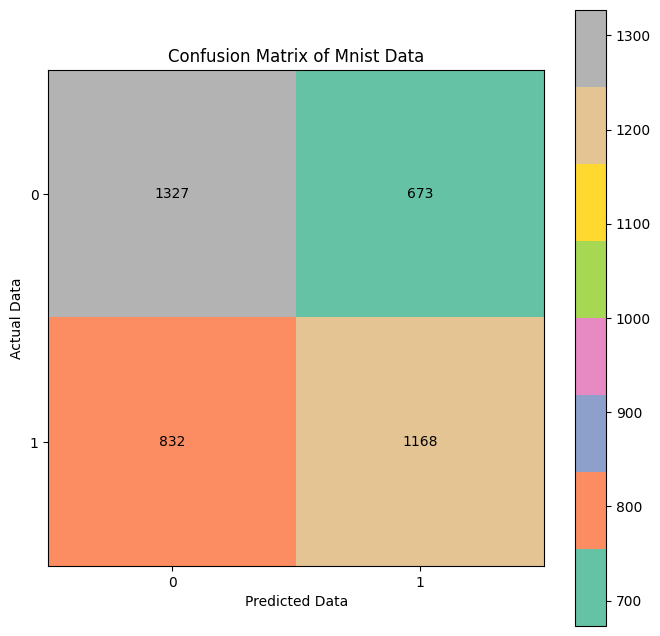

In [11]:
from sklearn import metrics
cm = metrics.confusion_matrix(y_test,y_pred)
plt.figure(figsize=(8,8))
plt.imshow(cm, cmap="Set2")

plt.xticks(np.arange(2))
plt.yticks(np.arange(2))

plt.xlabel("Predicted Data")
plt.ylabel("Actual Data")
plt.colorbar()

plt.title("Confusion Matrix of Mnist Data")

width, height = cm.shape
for x in range(width):
    for y in range(height):
        plt.annotate(str(cm[x][y]), xy=(y,x), horizontalalignment='center',verticalalignment='center')

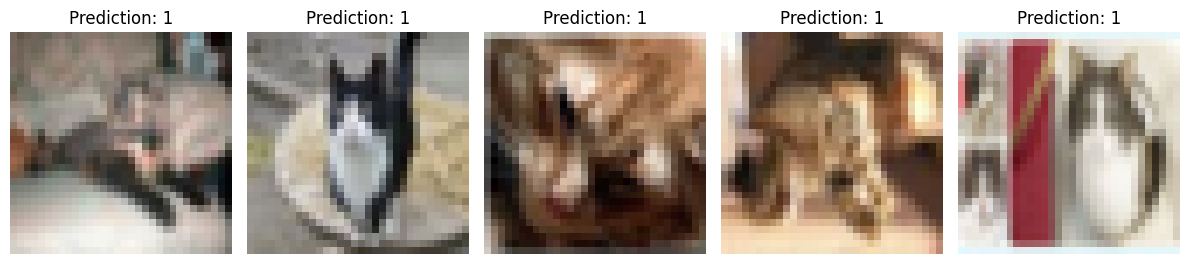

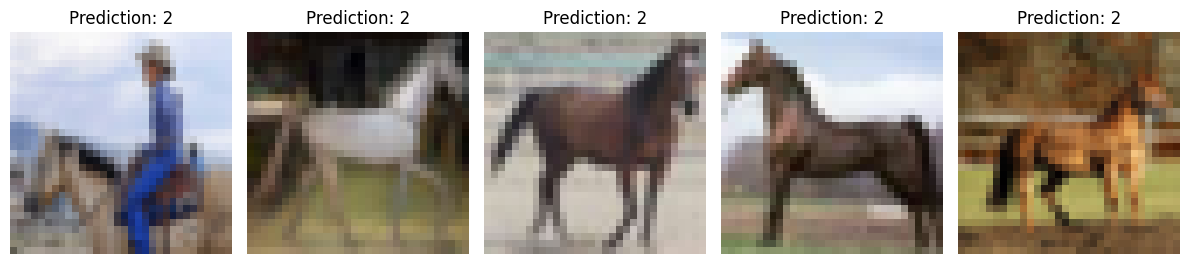

In [12]:
def plot_digit(digit_plot, num_images):
    digit = X_train[y_train == digit_plot]
    data = np.array(digit)
    fig, axes = plt.subplots(1, num_images, figsize=(12, 4))
    for i in range(num_images):
        ax = axes[i]
        ax.imshow(data[i].reshape(32, 32, 3))
        ax.axis('off')
        prediction = svm_clf.predict([data[i]])
        ax.set_title(f'Prediction: {prediction[0]}')
    plt.tight_layout()
    plt.show()
    
    
plot_digit(digit_plot=1,num_images=5)
plot_digit(digit_plot=2,num_images=5)

In [14]:
def get_adversarial_examples(x_train, y_train, attack_idx, x_val, y_val, kernel):
    attack_classifier = ScikitlearnClassifierSVC(model=SVC(kernel=kernel),clip_values=(0,255),nb_classes=nb_classes)
    attack_classifier.fit(x_train, y_train)
    init_attack = np.copy(x_train[attack_idx])
    y_attack = np.array([1, 1]) - np.copy(y_train[attack_idx])
    attack = PoisoningAttackSVM(attack_classifier, 0.01, 1.0, x_train, y_train, x_val, y_val, max_iter=10)
    x_attack, y_attack = attack.poison(np.array([init_attack]), y=np.array([y_attack]))
    return x_attack,y_attack
       

def save_single_poisoned_image(img, label, index, save_dir="./poisoned"):
    if img.ndim == 1 and img.shape[0] == 3072:
        img = img.reshape(3, 32, 32).transpose(1, 2, 0)
    
    if img.dtype in [np.float32, np.float64]:
        img = img.clip(0, 255).astype(np.uint8)

    img_pil = Image.fromarray(img)
    filename = f"{label}_{index}.png"
    img_pil.save(os.path.join(save_dir, filename))

def get_adversarial_examples_cnn(x_train, y_train, attack_idx, x_val, y_val):
    model = SmallCNN(num_classes=3)
    attacker = PoisoningAttackCNN(
        classifier=model,
        x_train=x_train.reshape(200, 3, 32, 32),
        y_train=y_train,
        x_val=x_val.reshape(800, 3, 32, 32),
        y_val=y_val,
        step_size=0.01,
        eps=1e-4,
        max_iter=10
    )
    init_attack = x_train[attack_idx]
    init_attack = torch.tensor(init_attack).float().to("cpu")
    init_attack = init_attack.unsqueeze(0)
    y_attack = 1 - y_train[attack_idx]
    x_attack = attacker.poison(init_attack, y_attack)
    return x_attack, y_attack

In [15]:
num_poisoned_samples=200
x_poison=X_train
y_poison=y_train

from concurrent.futures import ProcessPoolExecutor, as_completed
import numpy as np

def generate_single_attack(attack_idx):
    # x_attackpoint, y_attackpoint = get_adversarial_examples(X_train, y_train_ohe, attack_idx, X_test, y_val_ohe, "linear")
    x_attackpoint, y_attackpoint = get_adversarial_examples_cnn(X_train, y_train_ohe, attack_idx, X_val, y_val_ohe)
    id_array = np.argmax(y_attackpoint, axis=1)
    y_attackpoint = np.where(id_array == 0, target_digit1, target_digit2)
    
    save_single_poisoned_image(x_attackpoint[0], y_attackpoint[0], attack_idx)
    
    return x_attackpoint, y_attackpoint

x_poison_list = []
y_poison_list = []

with ProcessPoolExecutor() as executor:
    futures = [executor.submit(generate_single_attack, attack_idx) for attack_idx in range(num_poisoned_samples)]
    
    for future in as_completed(futures):
        x_attackpoint, y_attackpoint = future.result()
        x_poison_list.append(x_attackpoint)
        y_poison_list.append(y_attackpoint)

x_poison = np.concatenate(x_poison_list, axis=0)
y_poison = np.concatenate(y_poison_list, axis=0)



/home/desjardins/Repos/SVM-Poisoning/poisoning.py:312: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attack_point = torch.tensor(x_attack_init, requires_grad=True, dtype=torch.float32, device=self.device)
/home/desjardins/Repos/SVM-Poisoning/poisoning.py:312: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attack_point = torch.tensor(x_attack_init, requires_grad=True, dtype=torch.float32, device=self.device)
/home/desjardins/Repos/SVM-Poisoning/poisoning.py:313: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch

RuntimeError: Tensors must have same number of dimensions: got 4 and 2

Let us check if our attack was successful or not

Create a new classifier to assess the misclassification potential of our poisoned data.

In [ ]:
svm_clf2 = SVC(kernel='linear', C=1.0, random_state=42, max_iter=10000)
svm_clf2.fit(np.concatenate((X_train, x_poison), axis=0), np.concatenate((y_train, y_poison), axis=0))
y_pred2 = svm_clf2.predict(X_test)
accuracy = accuracy_score(y_test, y_pred2)
print("Accuracy: {:.2%}".format(accuracy))

svm_clf2 = SVC(kernel='linear', C=1.0, random_state=42, max_iter=10000)
svm_clf2.fit(X_train, y_train)
y_pred2 = svm_clf2.predict(X_test)
accuracy = accuracy_score(y_test, y_pred2)
print("Accuracy: {:.2%}".format(accuracy))

# Original: 66.55
# 200 poisoned samples: 52.78
# 200 flipped samples: 54.15

class_1_indices = np.where(y_val == 1)[0]  # Get indices where the label is 1
x_val_class_1 = X_val[class_1_indices]
y_val_class_1 = y_val[class_1_indices]

selected_indices = np.random.choice(len(x_val_class_1), size=200, replace=False)
x_val_flipped = x_val_class_1[selected_indices]
y_val_flipped = y_val_class_1[selected_indices]

y_val_flipped[:] = 2

X_train_with_poison = np.concatenate((X_train, x_val_flipped), axis=0)
y_train_with_poison = np.concatenate((y_train, y_val_flipped), axis=0)

svm_clf2 = SVC(kernel='linear', C=1.0, random_state=42)
svm_clf2.fit(X_train_with_poison, y_train_with_poison)

y_pred2 = svm_clf2.predict(X_test)

accuracy = accuracy_score(y_test, y_pred2)
print("Accuracy: {:.2%}".format(accuracy))


/home/desjardins/.cache/pypoetry/virtualenvs/svm-poisoning-haL7P6RK-py3.13/lib/python3.13/site-packages/sklearn/svm/_base.py:305: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Accuracy: 52.78%
Accuracy: 66.55%
Accuracy: 54.15%
